In [5]:
import pandas as pd
import numpy as np
import importlib
import collections
import seaborn as sns
from matplotlib import pyplot
import time
import scispacy
import spacy
import nltk
nltk.download('punkt')
str_version_db_name = 'mBase_15Aug'
csv_input_file_name = str_version_db_name + "_abstract.csv"
csv_output_file_name = str_version_db_name + "_abstract[chemical_gen].csv"
results = pd.read_csv(csv_input_file_name)
gtrain = pd.read_csv("data/garlic_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
ctrain = pd.read_csv("data/cocoa_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
btrain = pd.read_excel('Basil_Papers_with_Predicted_Labels v1.0.xls')
btrain['food'] = 'basil'
results['food'] = 'milk'
gtrain['food'] = 'garlic'
ctrain['food'] = 'cocoa'

[nltk_data] Downloading package punkt to /home/parthb1024/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
for i in range(len(btrain)):
    if btrain['is_useful'].loc[i] == 'x':
        btrain['is_useful'].loc[i] = 0

/home/parthb1024/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

def feature_gen(dataframe):
    
    meas_method_column_vals = []
    entity_nlp = spacy.load('en_core_sci_sm')
    chemical_disease_nlp = spacy.load('en_ner_bc5cdr_md')
    chem_ent_ratios, seen_chem, chem_count = [], [], []
    human_bigram = []    
    for index, row in dataframe.iterrows():
        abstract = row['abstract']
    #   ------------ Chemical Names ----------------
        entity_doc = entity_nlp(abstract)
        chemical_disease_doc = chemical_disease_nlp(abstract)
        chemical_ents = [ent.text for ent in chemical_disease_doc.ents if ent.label_ == 'CHEMICAL']
        if len(entity_doc.ents) == 0:
            chem_ent_ratios.append(0)
        else:
            chem_ent_ratios.append(len(chemical_ents) / len(entity_doc.ents))
        seen_chem.append(list(set(chemical_ents)))
        chem_count.append(len(chemical_ents))
    #   ------------ Bigram Score --------------
        tokens = nltk.word_tokenize(abstract)
        bigrams = nltk.bigrams(tokens)
        stopset = set(stopwords.words('english') + list(string.punctuation))
        milk_bigrams = [(w1, w2) for w1, w2 in bigrams if 
                        (w1.lower() == 'milk' or w2.lower() == 'milk')
                         and (w1.lower() not in stopset and w2.lower() not in stopset)]
        human_bigrams = [(w1, w2) for w1, w2 in milk_bigrams if 
                         (w1.lower() == 'human' or w2.lower() == 'human')
                         and (w1.lower() not in stopset and w2.lower() not in stopset)]
        human_bigram.append(len(human_bigrams) / len(milk_bigrams) if len(milk_bigrams) != 0 else 0)

    dataframe['chem_ent_ratio'] = chem_ent_ratios
    dataframe['chemicals'] = seen_chem
    dataframe['bigram_score'] = human_bigram
    dataframe['chem_term_count'] = chem_count
    
    return dataframe

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parthb1024/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
gresults = feature_gen(gtrain)
cresults = feature_gen(ctrain)
mresults = feature_gen(results)
bresults = feature_gen(btrain)
bresults

,Unnamed: 0,PMID,abstract,journal,mesh_UIds,mesh_terms,paper,qual_UIds,qual_terms,webpage,year,predicted_usefulness,is_useful,comments,food,chem_ent_ratio,chemicals,bigram_score,chem_term_count
0,10,29332819,The genus Ocimum (Labiatae) comprises 30 speci...,Talanta,"['D000080462', 'D000840', 'D002849', 'D002934'...","['Acyclic Monoterpenes', 'Anisoles', 'Chromato...",Chemometric analysis of NMR and GC datasets fo...,"[None, 'Q000032', 'Q000379', 'Q000032', 'Q0000...","[None, 'analysis', 'methods', 'analysis', 'ana...",https://www.ncbi.nlm.nih.gov/pubmed/29332819,2018,1,1,Essential oil,basil,0.119048,"[methyl chavicol, methyl cinnamate, eugenol, O...",0,5
1,24,26797599,Solvent-free microwave extraction (SFME) and c...,"Molecules (Basel, Switzerland)","['D000890', 'D000975', 'D057168', 'D008401', '...","['Anti-Infective Agents', 'Antioxidants', 'Dis...",Comparative Study of Essential Oils Extracted ...,"['Q000737', 'Q000737', 'Q000379', None, None, ...","['chemistry', 'chemistry', 'methods', None, No...",https://www.ncbi.nlm.nih.gov/pubmed/26797599,2016,1,1,Essential oil,basil,0.104478,"[hydro-distillation, Ocimum basilicum L.) leav...",0,7
2,26,26471526,In this study Ocimum basilicum L. (OB) and Oci...,Food chemistry,"['D002851', 'D005054', 'D066298', 'D018649', '...","['Chromatography, High Pressure Liquid', 'Euge...",Can Ocimum basilicum L. and Ocimum tenuiflorum...,"['Q000379', 'Q000737', None, 'Q000737', 'Q0007...","['methods', 'chemistry', None, 'chemistry', 'c...",https://www.ncbi.nlm.nih.gov/pubmed/26471526,2016,1,1,"Eugenol, phenolics",basil,0.234043,"[eugenol, OT, vanillin, vanillic acids, Eugenol]",0,11
3,27,26470193,The fumigant activity of essential oil vapors ...,Journal of economic entomology,"['D000818', 'D005651', 'D007306', 'D007814', '...","['Animals', 'Fumigation', 'Insecticides', 'Lar...",Fumigant Toxicity of Essential Oils from Basil...,"[None, None, 'Q000032', None, None, 'Q000737',...","[None, None, 'analysis', None, None, 'chemistr...",https://www.ncbi.nlm.nih.gov/pubmed/26470193,2015,1,1,Essential oil,basil,0.111111,"[eugenol, spearmint oil carvone, spearmint Men...",0,9
4,30,25522548,The composition of hydrodistilled essential oi...,Natural product communications,"['D000080462', 'D000840', 'D000935', 'D003511'...","['Acyclic Monoterpenes', 'Anisoles', 'Antifung...",Compositional variability and antifungal poten...,"[None, 'Q000737', 'Q000737', 'Q000737', None, ...","[None, 'chemistry', 'chemistry', 'chemistry', ...",https://www.ncbi.nlm.nih.gov/pubmed/25522548,2015,1,1,Essential oil,basil,0.209677,"[Ocimum basilicum L., methyl chavicol, monoter...",0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,87,11355006,Fatty acids are known as modulators of the vas...,Cellular and molecular biology (Noisy-le-Grand...,"['D015720', 'D002458', 'D002478', 'D016895', '...","[""5'-Nucleotidase"", 'Cell Fractionation', 'Cel...","Omegacoeur, a Mediterranean nutritional comple...","['Q000378', None, None, None, None, 'Q000166',...","['metabolism', None, None, None, None, 'cytolo...",https://www.ncbi.nlm.nih.gov/pubmed/11355006,2001,0,0,K-ATPase activity,basil,0.230769,"[lipids, Omegacoeur, lecithin, fatty acids, li...",0,18
89,89,10606575,"In this paper, three dissolution methods using...",Journal of agricultural and food chemistry,"['D000704', 'D002118', 'D002623', 'D003300', '...","['Analysis of Variance', 'Calcium', 'Chemistry...",Comparison of digestion methods for determinat...,"[None, 'Q000032', 'Q000379', 'Q000032', None, ...","[None, 'analysis', 'methods', 'analysis', None...",https://www.ncbi.nlm.nih.gov/pubmed/10606575,2000,0,1,Minerals,basil,0.344828,"[Cu, Fe, Ocimum basilicum, Allium, Mn, Ca, Mg,...",0,20
90,90,9703700,A surway is presented on the authors' work in ...,Acta pharmaceutica Hungarica,"['D020843', 'D002849', 'D005419', 'D019684', '...","['Chamomile', 'Chromatography, Gas', 'Flavonoi...","[Phytochemical evaluation of essential oils, m...","[None, 'Q000379', 'Q0

In [10]:
gresults['bigram_score'] = 1
cresults['bigram_score'] = 1
bresults['bigram_score'] = 1
mresults

,PMID,abstract,journal,mesh_UIds,mesh_terms,paper,qual_UIds,qual_terms,webpage,year,is_useful,source,measmethod,food,chem_ent_ratio,chemicals,bigram_score,chem_term_count
0,11425797.0,"Specific human milk oligosaccharides, especial...",Glycobiology,"['D002236', 'D002240', 'D002851', 'D005260', '...","['Carbohydrate Conformation', 'Carbohydrate Se...",Fucosylated human milk oligosaccharides vary b...,"[None, None, None, None, 'Q000032', None, None...","[None, None, None, None, 'analysis', None, Non...",https://www.ncbi.nlm.nih.gov/pubmed/11425797,2001.0,1.0,Chaturvedi_01,['HPLC'],milk,0.011364,[fucosyloligosaccharides],0.200,1
1,17073150.0,The dependence of daily vitamin excretion with...,Bulletin of experimental biology and medicine,"['D000328', 'D001942', 'D002851', 'D005260', '...","['Adult', 'Breast Feeding', 'Chromatography, H...",Evaluation of the vitamin status in nursing wo...,"[None, None, None, None, None, 'Q000737', None...","[None, None, None, None, None, 'chemistry', No...",https://www.ncbi.nlm.nih.gov/pubmed/17073150,2006.0,1.0,Kodentsova_06,['HPLC'],milk,0.423077,"[vitamins A, vitamins, vitamin B6, vitamin B2,...",0.000,11
2,17941914.0,The sources and the impact of maternal bacteri...,Clinical and experimental allergy : journal of...,"['D039941', 'D001644', 'D005243', 'D005260', '...","['Bifidobacteriales Infections', 'Bifidobacter...",Maternal breast-milk and intestinal bifidobact...,"['Q000382', 'Q000502', 'Q000382', None, None, ...","['microbiology', 'physiology', 'microbiology',...",https://www.ncbi.nlm.nih.gov/pubmed/17941914,2008.0,0.0,Gronlund__07,[],milk,0.000000,[],0.000,0
3,25221936.0,The benefits of human milk for preterm infants...,Journal of pediatric gastroenterology and nutr...,"['D000328', 'D053000', 'D000837', 'D002240', '...","['Adult', 'Analytic Sample Preparation Methods...",Effect of holder pasteurisation on human milk ...,"[None, None, None, None, None, None, 'Q000032'...","[None, None, None, None, None, None, 'analysis...",https://www.ncbi.nlm.nih.gov/pubmed/25221936,2015.0,1.0,Coscia_15,"['HPLC', 'Fluorometry']",milk,0.000000,[],0.400,0
4,12741556.0,Sialyloligosaccharides and sialylglycoconjugat...,Journal of dairy science,"['D000818', 'D002417', 'D003126', 'D005260', '...","['Animals', 'Cattle', 'Colostrum', 'Female', '...",Concentrations of sialyloligosaccharides in bo...,"[None, 'Q000378', 'Q000737', None, 'Q000032', ...","[None, 'metabolism', 'chemistry', None, 'analy...",https://www.ncbi.nlm.nih.gov/pubmed/12741556,2003.0,0.0,Nakamura_03,[],milk,0.105263,"[sialyloligosaccharides, sialyloligosaccharide...",0.500,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,NaN,Milk composition of mammallian species varies ...,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,0.0,Malacarne_02,[],milk,0.039216,"[polyunsaturated fatty acids, fatty acid]",0.125,2
233,NaN,Pooled human milk was subjected to Holder past...,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,1.0,Lepri_97,"['TLC', 'GC', 'HRGC-MS']",milk,0.181818,"[fatty acids, triglyceride, FFA, FFAs, l-lactate]",0.500,6
234,NaN,"When it comes to feeding the newborn, human mi...",NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,0.0,Mead_08,[],milk,0.018868,[pesticides],1.000,1
235,NaN,Background and objectives: Many studies indica...,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,1.0,Aumeistere_19,[],milk,0.186207,"[linoleic, n-6, C18:1 n9c), fatty acids, C16:0...",0.650,27


67
231


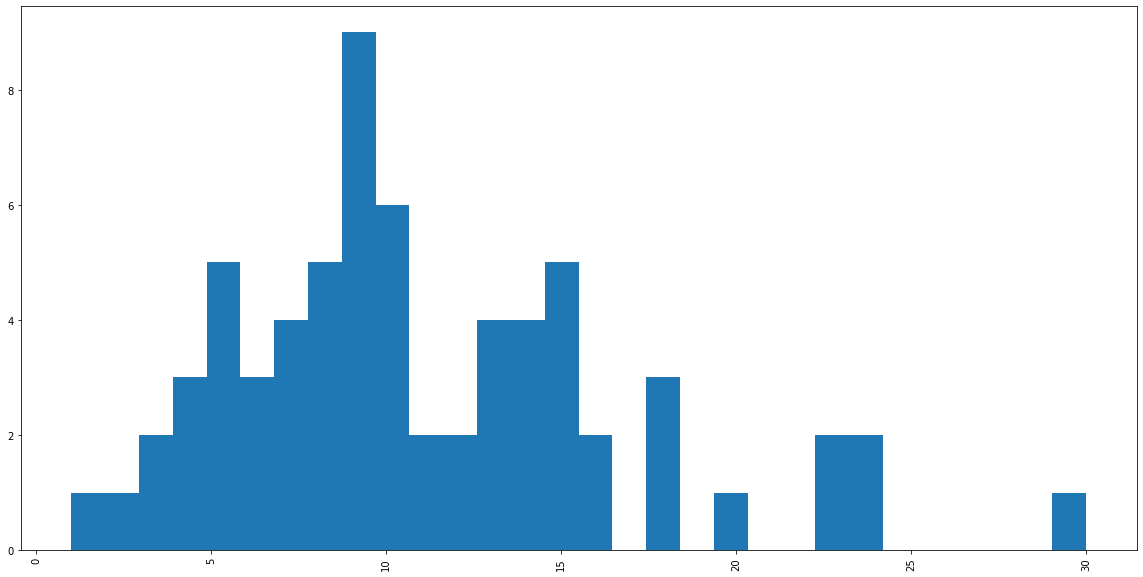

In [6]:
import matplotlib.pyplot as plt
all_chem_count = tuple(cresults[['chem_count', 'is_useful']].itertuples(index=False, name=None))
useful_chem = [chem_count for chem_count, is_useful in all_chem_count if is_useful == 1.0]
useless_chem = [chem_count for chem_count, is_useful in all_chem_count if is_useful == 0.0]
print(len(useful_chem))
print(len(useless_chem))
plt.figure(figsize=(20,10))
values_hist = plt.hist(useful_chem, bins=30)
plt.xticks(rotation=90)
plt.show()

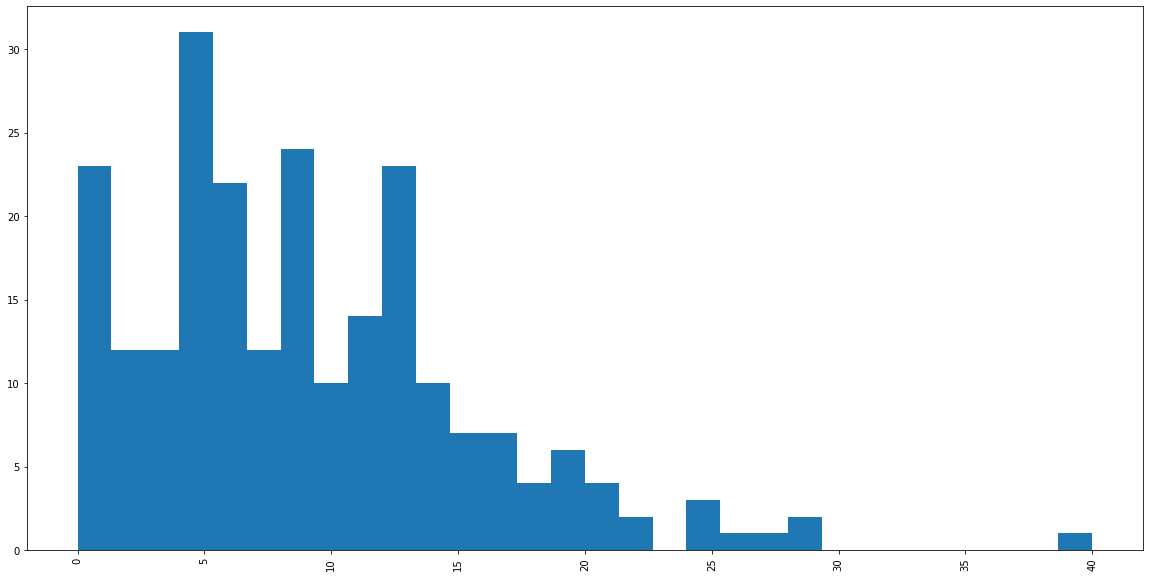

In [7]:
plt.figure(figsize=(20,10))
values_hist = plt.hist(useless_chem, bins=30)
plt.xticks(rotation=90)
plt.show()

In [11]:
mresults.to_csv(csv_output_file_name, index=False)
gresults.to_csv("garlic__abstract[chemical_gen].csv",index=False)
cresults.to_csv("cocoa__abstract[chemical_gen].csv",index=False)
bresults.to_csv("basil__abstract[chemical_gen].csv",index=False)